In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    precision_recall_curve
)

In [31]:
df = pd.read_csv("data/WBCD_dataset.csv")  # or WBCD_prognosis.csv

df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,R,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,R,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,R,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,R,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,R,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [32]:
df["diagnosis"].value_counts()

diagnosis
N    357
R    212
Name: count, dtype: int64

In [33]:
# --- Label Mapping: R/N → Benign/Malignant ---

LABEL_MAP = {"R": 1, "N": 0}

# Normalize text
df["diagnosis"] = (
    df["diagnosis"]
    .astype(str)
    .str.strip()
    .str.upper()
)

# Validate labels
unexpected = set(df["diagnosis"].unique()) - set(LABEL_MAP.keys())
if unexpected:
    raise ValueError(f"Unexpected labels found: {unexpected}")

# Create readable medical label
df["diagnosis_label"] = df["diagnosis"].map({
    "R": "Malignant",
    "N": "Benign"
})

# Create numeric target
df["target"] = df["diagnosis"].map(LABEL_MAP)

# Drop original column
df.drop(columns=["diagnosis"], inplace=True)

df["target"].value_counts()

target
0    357
1    212
Name: count, dtype: int64

In [34]:
if "Unnamed: 32" in df.columns:
    df.drop(columns=["Unnamed: 32"], inplace=True)

In [35]:
df.isnull().sum().sum()

np.int64(0)

In [36]:
df.duplicated().sum()

np.int64(0)

In [37]:
df = df.drop_duplicates()

In [38]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,569.0,3.037183e+07,1.250206e+08,8670.000000,869218.000000,906024.000000,8.813129e+06,9.113205e+08
radius_mean,569.0,1.412729e+01,3.524049e+00,6.981000,11.700000,13.370000,1.578000e+01,2.811000e+01
texture_mean,569.0,1.928965e+01,4.301036e+00,9.710000,16.170000,18.840000,2.180000e+01,3.928000e+01
perimeter_mean,569.0,9.196903e+01,2.429898e+01,43.790000,75.170000,86.240000,1.041000e+02,1.885000e+02
area_mean,569.0,6.548891e+02,3.519141e+02,143.500000,420.300000,551.100000,7.827000e+02,2.501000e+03
smoothness_mean,569.0,9.636028e-02,1.406413e-02,0.052630,0.086370,0.095870,1.053000e-01,1.634000e-01
compactness_mean,569.0,1.043410e-01,5.281276e-02,0.019380,0.064920,0.092630,1.304000e-01,3.454000e-01
concavity_mean,569.0,8.879932e-02,7.971981e-02,0.000000,0.029560,0.061540,1.307000e-01,4.268000e-01
concave points_mean,569.0,4.891915e-02,3.880284e-02,0.000000,0.020310,0.033500,7.400000e-02,2.012000e-01
symmetry_mean,569.0,1.811619e-01,2.741428e-02,0.106000,0.161900,0.179200,1.957000e-01,3.040000e-01


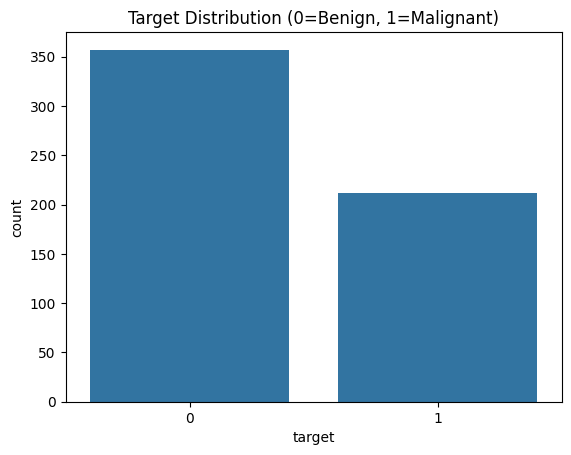

In [39]:
sns.countplot(x="target", data=df)
plt.title("Target Distribution (0=Benign, 1=Malignant)")
plt.show()

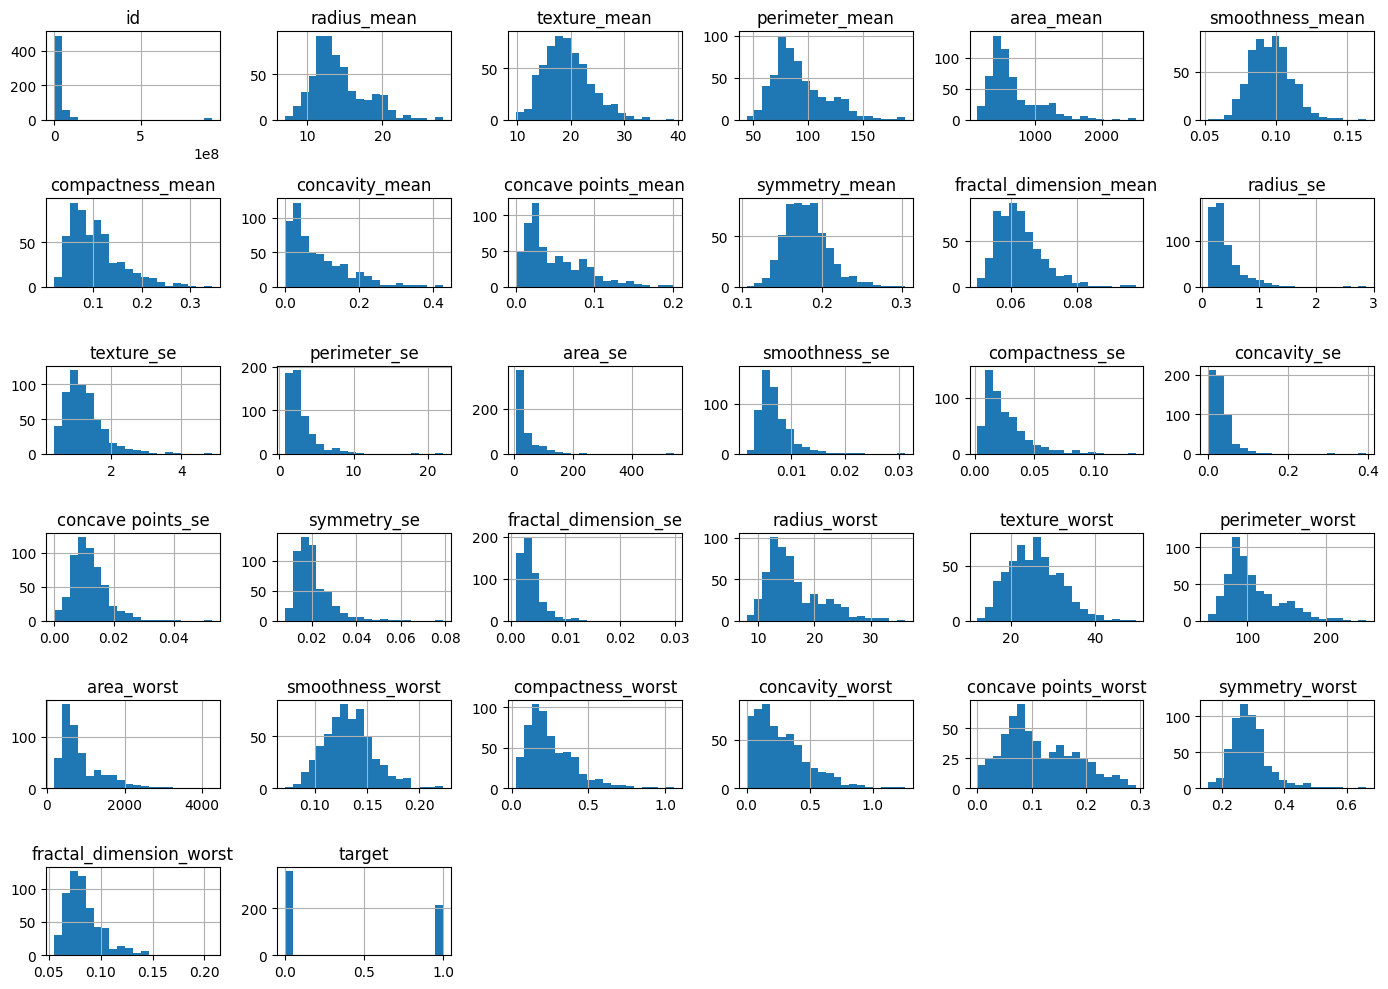

In [40]:
df.hist(figsize=(14, 10), bins=20)
plt.tight_layout()
plt.show()

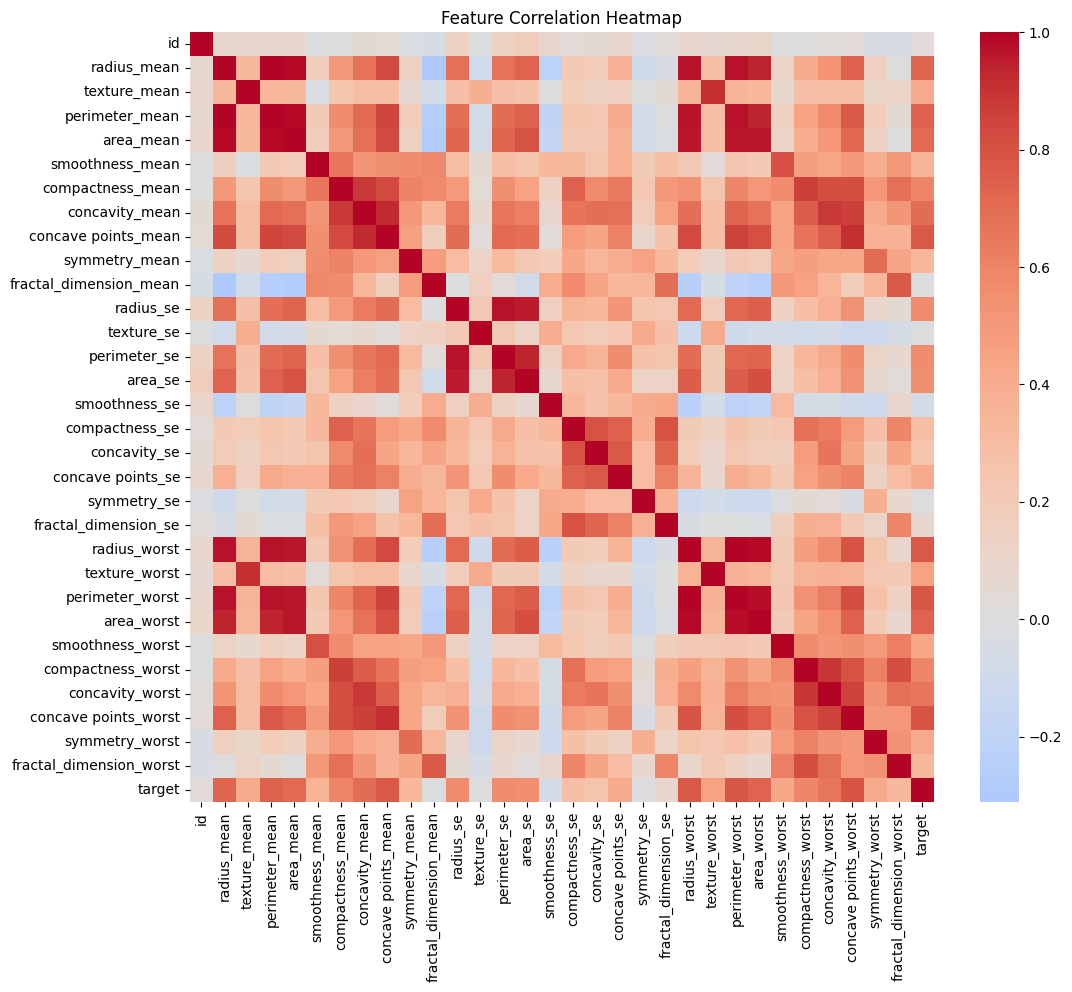

In [42]:
# Select only numeric columns
numeric_df = df.select_dtypes(include=["number"])

plt.figure(figsize=(12, 10))
sns.heatmap(numeric_df.corr(), cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

In [46]:
# Keep only numeric columns for modeling
X = df.select_dtypes(include=["number"]).drop(columns=["target"])
y = df["target"]

print("Feature shape:", X.shape)
print("Target shape:", y.shape)

Feature shape: (569, 31)
Target shape: (569,)


In [47]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print(X_train.shape, X_val.shape, X_test.shape)

(398, 31) (85, 31) (86, 31)


In [48]:
logreg_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=5000, class_weight="balanced"))
])

logreg_pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('clf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work

In [49]:
proba_lr = logreg_pipeline.predict_proba(X_val)[:, 1]

print("ROC-AUC:", roc_auc_score(y_val, proba_lr))
print("PR-AUC:", average_precision_score(y_val, proba_lr))

print(classification_report(y_val, (proba_lr >= 0.5).astype(int)))

ROC-AUC: 0.995872641509434
PR-AUC: 0.9938830876330876
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        53
           1       1.00      0.91      0.95        32

    accuracy                           0.96        85
   macro avg       0.97      0.95      0.96        85
weighted avg       0.97      0.96      0.96        85



In [50]:
rf = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestClassifier(
        n_estimators=500,
        random_state=42,
        class_weight="balanced"
    ))
])

rf_calibrated = CalibratedClassifierCV(rf, method="isotonic", cv=5)
rf_calibrated.fit(X_train, y_train)

,"estimator estimator: estimator instance, default=NoneThe classifier whose output need to be calibrated to provide moreaccurate `predict_proba` outputs. The default classifier isa :class:`~sklearn.svm.LinearSVC`... versionadded:: 1.2",Pipeline(step...m_state=42))])
,"method method: {'sigmoid', 'isotonic', 'temperature'}, default='sigmoid'The method to use for calibration. Can be:- 'sigmoid', which corresponds to Platt's method (i.e. a binary logistic regression model).- 'isotonic', which is a non-parametric approach.- 'temperature', temperature scaling.Sigmoid and isotonic calibration methods natively support only binaryclassifiers and extend to multi-class classification using a One-vs-Rest (OvR)strategy with post-hoc renormalization, i.e., adjusting the probabilities aftercalibration to ensure they sum up to 1.In contrast, temperature scaling naturally supports multi-class calibration byapplying `softmax(classifier_logits/T)` with a value of `T` (temperature)that optimizes the log loss.For very uncalibrated classifiers on very imbalanced datasets, sigmoidcalibration might be preferred because it fits an additional interceptparameter. This helps shift decision boundaries appropriately when theclassifier being calibrated is biased towards the majority class.Isotonic calibration is not recommended when the number of calibration samplesis too low ``(≪1000)`` since it then tends to overfit... versionchanged:: 1.8 Added option 'temperature'.",'isotonic'
,"cv cv: int, cross-validation generator, or iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross-validation,- integer, to specify the number of folds.- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if ``y`` is binary or multiclass,:class:`~sklearn.model_selection.StratifiedKFold` is used. If ``y`` isneither binary nor multiclass, :class:`~sklearn.model_selection.KFold`is used.Refer to the :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors.Base estimator clones are fitted in parallel across cross-validationiterations.See :term:`Glossary ` for more details... versionadded:: 0.24",None
,"ensemble ensemble: bool, or ""auto"", default=""auto""Determines how the calibrator is fitted.""auto"" will use `False` if the `estimator` is a:class:`~sklearn.frozen.FrozenEstimator`, and `True` otherwise.If `True`, the `estimator` is fitted using training data, andcalibrated using testing data, for each `cv` fold. The final estimatoris an ensemble of `n_cv` fitted classifier and calibrator pairs, where`n_cv` is the number of cross-validation folds. The output is theaverage predicted probabilities of all pairs.If `False`, `cv` is used to compute unbiased predictions, via:func:`~sklearn.model_selection.cross_val_predict`, which are thenused for calibration. At prediction time, the classifier used is the`estimator` trained on all the data.Note that this method is also internally implemented in:mod:`sklearn.svm` estimators with the `probabilities=True` parameter... versionadded:: 0.24.. versionchanged:: 1.6 `""auto""` option is added and is the default.",'auto'
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit 

In [51]:
proba_rf = rf_calibrated.predict_proba(X_val)[:, 1]

print("ROC-AUC:", roc_auc_score(y_val, proba_rf))
print("PR-AUC:", average_precision_score(y_val, proba_rf))

print(classification_report(y_val, (proba_rf >= 0.5).astype(int)))

ROC-AUC: 0.9958726415094339
PR-AUC: 0.9937704248366013
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        53
           1       1.00      0.91      0.95        32

    accuracy                           0.96        85
   macro avg       0.97      0.95      0.96        85
weighted avg       0.97      0.96      0.96        85



In [52]:
param_grid = {
    "clf__C": [0.01, 0.1, 1, 10]
}

grid = GridSearchCV(
    logreg_pipeline,
    param_grid,
    cv=5,
    scoring="average_precision"
)

grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)

Best Params: {'clf__C': 0.1}


In [53]:
models = {
    "LogReg": proba_lr,
    "RandomForest": proba_rf
}

for name, proba in models.items():
    print(f"\n{name}")
    print("ROC-AUC:", roc_auc_score(y_val, proba))
    print("PR-AUC:", average_precision_score(y_val, proba))


LogReg
ROC-AUC: 0.995872641509434
PR-AUC: 0.9938830876330876

RandomForest
ROC-AUC: 0.9958726415094339
PR-AUC: 0.9937704248366013


In [54]:
best_model = rf_calibrated  # or grid.best_estimator_

proba_test = best_model.predict_proba(X_test)[:, 1]

print("Test ROC-AUC:", roc_auc_score(y_test, proba_test))
print("Test PR-AUC:", average_precision_score(y_test, proba_test))

print(classification_report(y_test, (proba_test >= 0.5).astype(int)))

Test ROC-AUC: 1.0
Test PR-AUC: 1.0
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        54
           1       1.00      0.97      0.98        32

    accuracy                           0.99        86
   macro avg       0.99      0.98      0.99        86
weighted avg       0.99      0.99      0.99        86



In [55]:
os.makedirs("models", exist_ok=True)

joblib.dump({
    "model": best_model,
    "features": X.columns.tolist()
}, "models/model_a.pkl")

print("Model saved successfully.")

Model saved successfully.


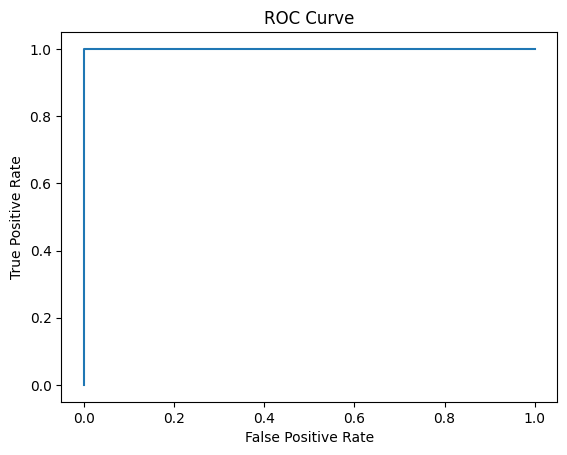

In [56]:
fpr, tpr, _ = roc_curve(y_test, proba_test)

plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

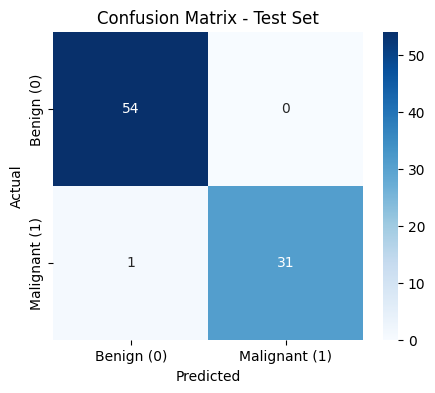

In [57]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate predictions using 0.5 threshold
y_pred_test = (proba_test >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benign (0)", "Malignant (1)"],
            yticklabels=["Benign (0)", "Malignant (1)"])

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Test Set")
plt.show()

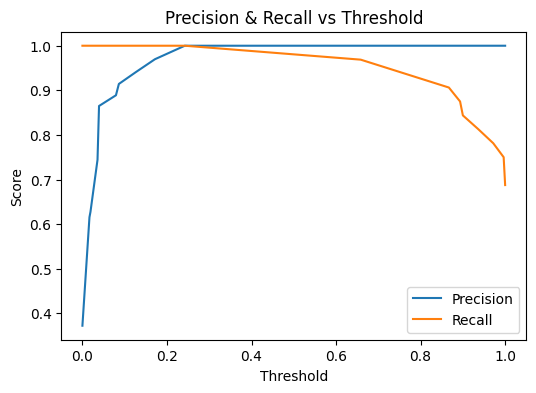

In [58]:
import numpy as np
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, proba_test)

# Plot precision-recall vs threshold
plt.figure(figsize=(6, 4))
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision & Recall vs Threshold")
plt.legend()
plt.show()

In [59]:
custom_threshold = 0.4
y_pred_adjusted = (proba_test >= custom_threshold).astype(int)

print("Classification Report (Threshold=0.4):")
print(classification_report(y_test, y_pred_adjusted))

Classification Report (Threshold=0.4):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        54
           1       1.00      0.97      0.98        32

    accuracy                           0.99        86
   macro avg       0.99      0.98      0.99        86
weighted avg       0.99      0.99      0.99        86



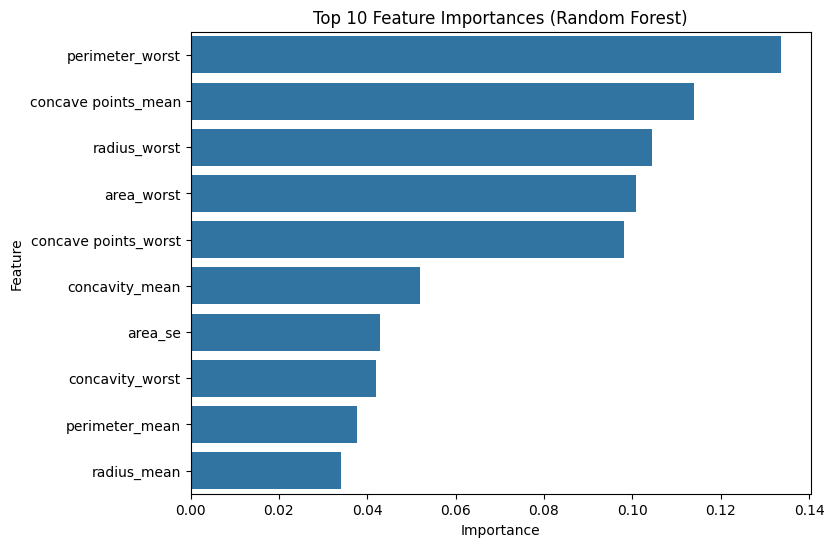

,Feature,Importance
23,perimeter_worst,0.133642
8,concave points_mean,0.114003
21,radius_worst,0.104332
24,area_worst,0.100773
28,concave points_worst,0.098082
7,concavity_mean,0.051940
14,area_se,0.042838
27,concavity_worst,0.042027
3,perimeter_mean,0.037767
1,radius_mean,0.034083


In [61]:
# Access fitted RF model inside calibration
fitted_pipeline = rf_calibrated.calibrated_classifiers_[0].estimator

rf_model = fitted_pipeline.named_steps["rf"]

importances = rf_model.feature_importances_
feature_names = X.columns

importance_df = (
    pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances
    })
    .sort_values(by="Importance", ascending=False)
)

plt.figure(figsize=(8, 6))
sns.barplot(
    x="Importance",
    y="Feature",
    data=importance_df.head(10)
)

plt.title("Top 10 Feature Importances (Random Forest)")
plt.show()

importance_df.head(10)